In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchvision
!pip install pyDOE

In [ ]:
import sys
sys.path.insert(0, '.')
import argparse
import os
import torch
from collections import OrderedDict
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import seaborn as sns
import pylab as py
import time
from pyDOE import lhs
import scipy
import warnings
sys.path.insert(0, '.')
warnings.filterwarnings('ignore')
np.random.seed(1234)

In [ ]:
!pip install pandas

In [ ]:
import pandas as pd

In [ ]:
data1 = pd.read_csv("/content/drive/MyDrive/NewReq_Arc1-features.csv")
df_features = pd.DataFrame(data1, columns = data1.columns)
#y = data1["sithic_value"].values
X = df_features
X
X['time_centered'] = pd.to_datetime(df_features['time_centered']).astype(int)
print(df_features.columns)
print(X.shape)

Index(['nav_lat', 'nav_lon', 'time_centered', 'sithic'], dtype='object')
(2221440, 4)


In [ ]:
df_features = pd.DataFrame(data1, columns = data1.columns)
y = data1["sithic"].values

In [ ]:
#Set the 75/25% train/test split, set a random state to get train/test for future analysis
X = df_features
X
X['time_centered'] = pd.to_datetime(df_features['time_centered']).astype(int)

In [ ]:
X.shape

(2221440, 4)

In [ ]:
B=X["nav_lon"].values
B

array([-58.420696, -53.43733 , 148.11154 , ...,  72.442535,  72.458015,
        72.47296 ])

In [ ]:
x= data1["nav_lon"].values
t=data1["time_centered"].values
t
df_features.dtypes

nav_lat          float64
nav_lon          float64
time_centered      int64
sithic           float64
dtype: object

In [ ]:
import pandas as pd
####Test differentiation#########

# Define the array of timestamps
time_strings = t

# Convert the strings to datetime objects
time_objects = pd.to_datetime(time_strings)

# Extract the dates
dates = time_objects.year

# Create a DataFrame with the year information
year_info = pd.DataFrame({'year': dates})


# Concatenate X DataFrame and year_info DataFrame horizontally
X_with_year = pd.concat([X, year_info], axis=1)

# Create a Pandas DataFrame
#df_date = pd.DataFrame(data={'dates': dates})

# Print the DataFrame

X_with_year
#nan_indices = year_info['year'].isnull().sum()
#nan_indices
# Filter X for data corresponding to the year 2007
X_2007 = X_with_year[X_with_year['year'] == 2014]
data1['time_derivative'] =year_info.diff()

data1['time_derivative']
# Display the updated DataFrame with extracted features for 2007
#print(X_2007)
time_objects_excluding_2007 = dates[dates != 2014]
time_objects_excluding_2007

Index([1975, 1975, 1975, 1975, 1975, 1975, 1975, 1975, 1975, 1975,
       ...
       2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013],
      dtype='int32', length=2165904)

In [ ]:
min_derivative = data1['time_derivative'].min()
max_derivative = data1['time_derivative'].max()

# Print the minimum and maximum values
print("Minimum value of 'time_derivative':", min_derivative)
print("Maximum value of 'time_derivative':", max_derivative)

Minimum value of 'time_derivative': 0.0
Maximum value of 'time_derivative': 1.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
# Filter X_with_year to exclude data from the year 2007
X_except_2007 = X_with_year[X_with_year['year'] != 2014]
y_except_2007 = y[X_with_year['year'] != 2014]

# Split the data excluding 2007 into training and testing sets
X_train_except_2007, X_test_except_2007, y_train_except_2007, y_test_except_2007 = train_test_split(
    X_except_2007, y_except_2007, test_size=0.2, random_state=0
)

# Filter X_with_year for data corresponding to the year 2007
X_2007 = X_with_year[X_with_year['year'] == 2014]
y_2007 = y[X_with_year['year'] == 2014]


In [ ]:
print(X_2007.values)
print(y_2007.dtype)

[[ 4.9599170e+01 -5.8420696e+01  1.3898736e+18  4.5051612e-02
   2.0140000e+03]
 [ 5.0527065e+01 -5.3437330e+01  1.3898736e+18  3.5513207e-01
   2.0140000e+03]
 [ 5.1792973e+01  1.4811154e+02  1.3898736e+18  7.2821360e-02
   2.0140000e+03]
 ...
 [ 6.9997670e+01  7.2442535e+01  1.4187312e+18  1.0973377e+00
   2.0140000e+03]
 [ 6.9552220e+01  7.2458015e+01  1.4187312e+18  1.2507676e+00
   2.0140000e+03]
 [ 6.9107480e+01  7.2472960e+01  1.4187312e+18  1.4002302e+00
   2.0140000e+03]]
float64


In [ ]:
X_2007=X_2007.values[:,[0,1,4]]


In [ ]:
print(X_train_except_2007.shape)
print(X_test_except_2007.shape)
print(y_train_except_2007.shape)
print(y_test_except_2007.shape)


(1732723, 5)
(433181, 5)
(1732723,)
(433181,)


In [ ]:
X_train=X_train_except_2007.values[:,[0,1,4]]
X_test=X_test_except_2007.values[:,[0,1,4]]
X_train.shape

(1732723, 3)

In [ ]:
X_star=X_test
u_star = y_test_except_2007
X_u_train = X_train
u_train=y_train_except_2007

In [ ]:
# Choose a random sample size (
sample_size = 10000

# Select random indices from the entire data range (0 to length-1)
random_indices = np.random.choice(X_star.shape[0], size=sample_size, replace=False)

# Select random data using the indices
X_star_random = X_star[random_indices]
u_star_random = u_star[random_indices]

# Similarly, for training data
random_indices_train = np.random.choice(X_u_train.shape[0], size=sample_size, replace=False)
X_u_train_random = X_u_train[random_indices_train]
u_train_random = u_train[random_indices_train]


In [ ]:
import numpy as np


# Number of elements not yet selected (might be less than 5000)
n_remaining = X_star.shape[0] - len(random_indices)

# Select a random sample size (up to available elements)
sample_size = min(1000, n_remaining)

# Randomly choose indices from the remaining set (if any)
if n_remaining > 0:
  # Ensure no duplicates between random_indices and chosen indices
  next_5000_indices = np.random.choice(np.setdiff1d(np.arange(X_star.shape[0]), random_indices), size=sample_size, replace=False)
  X_star_next_5000 = X_star[next_5000_indices]
else:
  # Handle the case where no elements are remaining (all might have been selected previously)
  print("No elements in X_star haven't been selected yet")


In [ ]:
X_f_train =X_star_next_5000
X_u_train_random
u_train_random

array([4.6202254 , 3.4149413 , 0.15174903, ..., 2.9091349 , 3.061613  ,
       1.5146224 ])

In [ ]:
print(X_f_train.shape)
print(X_u_train_random.shape)
print(u_train_random.shape)
print(u_star_random.shape)

(1000, 3)
(10000, 3)
(10000,)
(10000,)


In [ ]:
print(len(X_u_train_random))

10000


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
class Spline(nn.Module):
    def __init__(self, num_features, spline_order=4):
        super(Spline, self).__init__()
        self.num_features = num_features
        self.spline_order = spline_order
        self.coefficients = nn.Parameter(torch.randn(num_features, spline_order))

    def forward(self, x):
        # For simplicity, using a linear combination of input and spline coefficients
        spline_basis = torch.stack([x**i for i in range(self.spline_order)], dim=-1)
        out = torch.sum(spline_basis * self.coefficients, dim=-1)
        return out

class KANBlock(nn.Module):
    def __init__(self, in_features, out_features, spline_order=4):
        super(KANBlock, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.spline = Spline(out_features, spline_order)

    def forward(self, x):
        out = self.linear(x)
        out = self.spline(out)
        return out

class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_kan_layers=3):
        super(Net, self).__init__()

        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
                # Subsequent GRU layers
        self.lstm_layers = nn.ModuleList([
            nn.GRU(hidden_dim, hidden_dim, batch_first=True),
            nn.GRU(hidden_dim, hidden_dim, batch_first=True),
            nn.GRU(hidden_dim, hidden_dim, batch_first=True),
        ])


        # KAN blocks
        self.kan_layers = nn.ModuleList([KANBlock(hidden_dim, hidden_dim) for _ in range(num_kan_layers)])

        # Apply dropout between layers (optional)
        self.dropout = nn.Dropout(0.2)  # Adjust dropout probability as needed

        # Activation function (choose a suitable activation function)
        self.activation = nn.LeakyReLU()  # Example: ReLU activation

        # Final linear layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Reshape to 3D if necessary
        if len(x.shape) == 2:
            x = x.view(-1, 1, x.shape[1])

        # Pass input through RNN layer
        out, _ = self.rnn(x)

        h = None  # Initialize hidden state for GRU layers
        # Pass output from RNN through KAN layers with dropout and activation
        for layer in self.kan_layers:
            for lstm in self.lstm_layers:
                out, h = lstm(out, h)
            out = self.dropout(self.activation(layer(out)))

        # Use output from last timestep and apply linear layer
        out = self.fc(out[:, -1])
        return out

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io
from scipy.interpolate import griddata
from torch.utils.data import TensorDataset, DataLoader
import time
import torch.nn as nn

def set_seed(seed_value):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

# Set seed value for reproducibility
seed_value = 1234
set_seed(seed_value)

class BPINN(nn.Module):
    def __init__(self, x_u, y_u, x_f, X_star, u_star, net, nepochs, Omega_mse, noise = 0.1):
        super(BPINN, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Normalize data
        self.Xmean, self.Xstd = x_f.mean(0), x_f.std(0)
        self.x_f = (x_f - self.Xmean) / self.Xstd
        self.x_u = (x_u - self.Xmean) / self.Xstd
        self.X_star_norm = (X_star - self.Xmean) / self.Xstd
        self.u_star = u_star

        #Jacobian of the PDE because of normalization
        self.Jacobian_X = 1 / self.Xstd[0]
        self.Jacobian_Y = 1 / self.Xstd[1]
        self.Jacobian_T = 1 / self.Xstd[2]

        self.y_u = y_u + noise * np.std(y_u)*np.random.randn(y_u.shape[0])

        self.net = net


        #self.net_optim = torch.optim.Adagrad(self.net.parameters(), lr=0.001)
        #self.net_optim = torch.optim.RMSprop(self.net.parameters(), lr=0.001)
        #self.net_optim = torch.optim.SGD(self.net.parameters(), lr=0.001, momentum=0.9)
        #self.net_optim = torch.optim.AdamW(self.net.parameters(), lr=0.001)
        self.net_optim = torch.optim.Adam(self.net.parameters(), lr=0.001, betas = (0.9, 0.999))
        #self.device = device

        # numpy to tensor
        self.train_x_u = torch.tensor(self.x_u, requires_grad=True).float()
        self.train_y_u = torch.tensor(self.y_u, requires_grad=True).float()
        self.train_x_f = torch.tensor(self.x_f, requires_grad=True).float()
        self.X_star_norm = torch.tensor(self.X_star_norm, requires_grad=True).float()
        self.u_star = torch.tensor(self.u_star, requires_grad=True).float()

        self.nepochs = nepochs
        self.Omega_mse = Omega_mse

        self.batch_size = 100
        num_workers = 4
        shuffle = True
        self.train_loader = DataLoader(
            list(zip(self.train_x_u,self.train_y_u)), batch_size=self.batch_size, shuffle=shuffle
        )

        self.val_loader = DataLoader(
            list(zip(self.X_star_norm,self.u_star)), batch_size=self.batch_size, shuffle=shuffle
        )


    def seq(self, X):
        #print(X.shape)
        num_features = X.shape[1]
        timesteps = 10  # Example time window (adjust as needed)

        # Initialize output tensor for shifted features
        X_in = torch.zeros((len(X), timesteps, num_features), dtype=torch.float32)

    # Iterate through features and timesteps
        for i in range(num_features):
            for j in range(timesteps):
                # Shift feature values and fill any missing values with the previous value
                shifted_feature = torch.roll(X[:, i], timesteps - j - 1, dims=0)
                X_in[:, j, i] = shifted_feature

        return X_in

    def get_residual(self, X_in):

        X_in = self.seq(X_in)
        #print(X_in.shape)
        # physics loss for collocation/boundary points ###independent variables
        x = torch.tensor(X_in[:, :, 0:1], requires_grad=True).float()
        y = torch.tensor(X_in[:, :, 1:2], requires_grad=True).float()
        t = torch.tensor(X_in[:, :, 2:3], requires_grad=True).float()

        y_pred = self.net.forward(torch.cat([x, y, t], dim=2))
        u = y_pred[:,0:1]
        fh = self.phy_residual(x, y, t, u)
        return y_pred, fh

    def phy_residual(self, x, y, t, u, nu=0.5,L=0.5):
        """ The pytorch autograd version of calculating residual """

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_y = torch.autograd.grad(
            u, y,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        fh = (self.Jacobian_T) * u_t + (self.Jacobian_X) * 1 * u_x + (self.Jacobian_Y) * 1 * u_y  + nu + L
        return fh


    def cal_Omega(self, adaptive_lambda, phy_loss, loss, beta=0.1): #0.1
        phyloss_layer = []
        loss_layer = []
        with torch.no_grad():
            for layer in self.net.children():
                if isinstance(layer, nn.Linear) or isinstance(layer, nn.LSTM):
                    if isinstance(layer, nn.Linear):
                        phyloss_layer.append(torch.abs(torch.autograd.grad(phy_loss, layer.weight, retain_graph=True)[0]).max())
                        loss_layer.append(torch.abs(torch.autograd.grad(loss, layer.weight, retain_graph=True)[0]).mean())
                    elif isinstance(layer, nn.LSTM):
                        for param in layer.parameters():
                            if param.requires_grad:
                                phyloss_layer.append(torch.abs(torch.autograd.grad(phy_loss, param, retain_graph=True)[0]).max())
                                loss_layer.append(torch.abs(torch.autograd.grad(loss, param, retain_graph=True)[0]).mean())
        max_grad_res = torch.stack(phyloss_layer).max()
        mean_grad_loss = torch.stack(loss_layer).mean()
        lambda_new = max_grad_res / mean_grad_loss
        adaptive_lambda = (1 - beta) * adaptive_lambda + beta * lambda_new
        return adaptive_lambda


    def train(self, patience=15):
        TOT_loss = np.zeros(self.nepochs)
        MSE_loss = np.zeros(self.nepochs)
        PHY_loss = np.zeros(self.nepochs)
        VAL_loss = np.zeros(self.nepochs)

        epoch_times = []
        start_time = time.perf_counter()
        min_val_loss = 9999
        no_improvement_count = 0
        # Define the number of batches to accumulate gradients over
        accum_iter = 4  # Adjust this value based on your memory limitations
        for epoch in range(self.nepochs):
            epoch_loss = 0
            epoch_val_loss = 0

            for i, (x, y) in enumerate(self.train_loader):
                self.net_optim.zero_grad()
                y_pred, _ = self.get_residual(x)
                _, fh = self.get_residual(self.train_x_f)

                mse_loss = torch.nn.functional.mse_loss(y, y_pred)
                physics_loss = torch.mean(fh**2)

                self.Omega_mse = self.cal_Omega(self.Omega_mse, physics_loss, self.Omega_mse * mse_loss)

                # Add the deviation from mean to your loss
                loss = self.Omega_mse * mse_loss + physics_loss


                loss.backward(retain_graph=True)
                # Update weights after 'accum_iter' or last batch
                if (i + 1) % accum_iter == 0 or (i + 1) == len(self.train_loader):
                  self.net_optim.step()
                  self.net_optim.zero_grad()  # Reset gradients for next iteration
                self.net_optim.step()

                TOT_loss[epoch] += loss.detach().cpu().numpy()
                MSE_loss[epoch] += mse_loss.detach().cpu().numpy()
                PHY_loss[epoch] += physics_loss.detach().cpu().numpy()

            TOT_loss[epoch] /= len(self.train_loader)
            MSE_loss[epoch] /= len(self.train_loader)
            PHY_loss[epoch] /= len(self.train_loader)

            # Calculate validation loss
            #with torch.no_grad():
            self.net.eval()
            for x_val, y_val in self.val_loader:
                y_pred_val, _ = self.get_residual(x_val)
                val_mse_loss = torch.nn.functional.mse_loss(y_val, y_pred_val)
                epoch_val_loss += val_mse_loss.detach().cpu().numpy()
            VAL_loss[epoch] = epoch_val_loss / len(self.train_loader)

            if min_val_loss > val_mse_loss**0.2:#0.5
                min_val_loss = val_mse_loss**0.2

                torch.save(burgers.state_dict(), "/content/drive/MyDrive/KDD_LSTM-RNN-seq30.pt")

                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if no_improvement_count == patience:
                break

            if epoch % 10 == 0:
                print(
                    "[Epoch %d/%d] [Phy loss: %f] [Total loss: %f] [mse_loss: %f] [val_loss: %f]"
                    % (epoch, self.nepochs, PHY_loss[epoch], TOT_loss[epoch], MSE_loss[epoch], VAL_loss[epoch])
                )

        total_training_time = time.perf_counter() - start_time
        print("Total Training Time: {} seconds".format(total_training_time))
        plt.figure(figsize=(6, 6))
        plt.plot(MSE_loss, label='MSE loss')
        plt.plot(VAL_loss, label='VAL loss')
        plt.ylim(0, 9)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(False)
        plt.show()

In [ ]:
num_epochs = 150
Omega_mse = 1
noise = 0.01

In [ ]:
net=Net(input_dim=3, hidden_dim=64, output_dim=1,  num_kan_layers=3)

In [ ]:
burgers = BPINN(X_u_train_random, u_train_random, X_f_train, X_star_random, u_star_random, net, num_epochs, Omega_mse, noise)

[Epoch 0/150] [Phy loss: 0.997827] [Total loss: 2.665846] [mse_loss: 2.592628] [val_loss: 2.156227]
[Epoch 10/150] [Phy loss: 0.989570] [Total loss: 4.061777] [mse_loss: 2.174122] [val_loss: 2.167465]
[Epoch 20/150] [Phy loss: 0.998513] [Total loss: 2.859242] [mse_loss: 2.163191] [val_loss: 2.166425]
[Epoch 30/150] [Phy loss: 0.998125] [Total loss: 2.827559] [mse_loss: 2.165254] [val_loss: 2.155273]
[Epoch 40/150] [Phy loss: 0.997916] [Total loss: 3.062266] [mse_loss: 2.165553] [val_loss: 2.163430]
Total Training Time: 17006.179868211 seconds


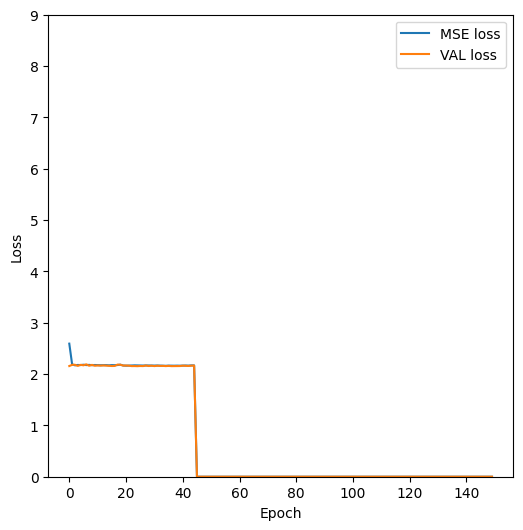

In [ ]:
burgers.train()


In [ ]:
import torch
import random
import numpy as np

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)


In [ ]:
def smape(y_true, y_pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE).
    """
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # Handle division by zero
    return np.mean(diff)*100/ len(y_true)

def mape(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE).
    """
    diff = np.abs(y_true - y_pred) / np.abs(y_true)
    diff[np.isnan(diff)] = 0.0  # Handle NaN values
    diff[np.isinf(diff)] = 0.0  # Handle infinite values
    return np.mean(diff) * 100 / len(y_true)

def theil_coefficient(y_true, y_pred):
    """
    Calculate Theil's Inequality Coefficient.
    """
    n = len(y_true)

    # Calculate three components
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    diff_true = y_true - mean_true
    diff_pred = y_pred - mean_pred

    # Calculate Theil's Inequality Coefficient
    num = np.sqrt(np.mean(diff_true**2)) + np.sqrt(np.mean(diff_pred**2))
    denom = np.sqrt(np.mean(y_true**2)) + np.sqrt(np.mean(y_pred**2))

    return num / denom

In [ ]:
batch_size = 64  # You can adjust this value as needed

# Convert X_2007 and y_2007 to tensors
X_2007_tensor = torch.tensor(X_2007, dtype=torch.float32)
y_2007_tensor = torch.tensor(y_2007, dtype=torch.float32)

# Calculate the total number of batches
num_samples = X_2007_tensor.size(0)
num_batches = (num_samples + batch_size - 1) // batch_size

# Initialize lists to store predictions and MSE losses
predictions = []
mse_losses = []
smape_values = []
mape_values = []
theil_coefficients = []

# Iterate over batches
for i in range(num_batches):
    # Calculate start and end indices for the current batch
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_samples)

    # Extract the current batch from X_2007_tensor and y_2007_tensor
    X_batch = X_2007_tensor[start_idx:end_idx]
    y_batch = y_2007_tensor[start_idx:end_idx]

    # Pass X_batch through the model to obtain predictions
    u_pred_batch, _ = burgers.get_residual(X_batch)
    predictions.append(u_pred_batch)

    # If you have ground truth data for 2007, calculate MSE loss for the current batch
    if y_batch is not None:
        mse_loss = torch.nn.functional.mse_loss(y_batch, u_pred_batch)
        mse_losses.append(mse_loss.item())

                # Calculate SMAPE
        smape_value = smape(y_batch.detach().numpy(), u_pred_batch.detach().numpy())
        smape_values.append(smape_value)
        mape_value = mape(y_batch.detach().numpy(), u_pred_batch.detach().numpy())
        mape_values.append(mape_value)


        # Calculate Theil coefficient
        theil_coefficient_value = theil_coefficient(y_batch.detach().numpy(), u_pred_batch.detach().numpy())
        theil_coefficients.append(theil_coefficient_value)

# Concatenate predictions and calculate overall MSE loss if applicable
u_pred_2007 = torch.cat(predictions, dim=0)
val_mse_loss = None
if y_2007_tensor is not None:
    val_mse_loss = sum(mse_losses) / len(mse_losses)
    print("Validation MSE for 2007:", val_mse_loss)
    print("Validation SMAPE for 2007:", np.mean(smape_values))
    print("Validation MAPE for 2007:", np.mean(mape_values))
    print("Validation Theil coefficient for 2007:", np.mean(theil_coefficients))


Validation MSE for 2007: 1.8564750657240916
Validation SMAPE for 2007: 0.9781627648634501
Validation MAPE for 2007: 6.513966445005664
Validation Theil coefficient for 2007: 0.18596333


In [ ]:
u_pred_2007.shape
print(torch.min(u_pred_2007))
print(torch.max(u_pred_2007))


tensor(2.2879, grad_fn=<MinBackward1>)
tensor(2.2882, grad_fn=<MaxBackward1>)


In [ ]:
print(X_2007.shape)
print(y_2007.shape)

(55536, 3)
(55536,)


In [ ]:
print(u_pred_2007.shape)

torch.Size([55536, 1])


In [ ]:
!pwd


/content
